In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("data/final_X_y_smoothed_wtested_positive_14d.csv")
target_var = "smoothed_wtested_positive_14d"
exclude_cols = ['time_value', 'geo_value', 'is_pseudo', target_var]

In [3]:
# Split X/y
X = df.drop(columns=[col for col in exclude_cols if col in df.columns])
y = df[target_var]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# Define models
models = {
    "Ridge": RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5),
    "Lasso": LassoCV(alphas=[0.001, 0.01, 0.1], max_iter=1000, cv=5),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42),
    "NeuralNet": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

In [5]:
results = {}
fitted_models = {}

In [6]:
print("Starting model training and evaluation...\n")

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)

    print(f"Predicting with {name}...")
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    }

    fitted_models[name] = model
    print(f"{name} done. MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}\n")

print("All models finished!\n")

# Show results
results_df = pd.DataFrame(results).T.sort_values("R²", ascending=False)
print("Model Performance on Test Set:")
display(results_df)

Starting model training and evaluation...

⚙️Training Ridge...
Predicting with Ridge...
Ridge done. MAE: 2.940 | RMSE: 3.790 | R²: 0.627

⚙️Training Lasso...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Predicting with Lasso...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Lasso done. MAE: 2.939 | RMSE: 3.790 | R²: 0.627

⚙️Training XGBoost...
Predicting with XGBoost...
XGBoost done. MAE: 2.024 | RMSE: 2.637 | R²: 0.820

⚙️Training NeuralNet...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Predicting with NeuralNet...
NeuralNet done. MAE: 2.561 | RMSE: 3.290 | R²: 0.719

All models finished!

Model Performance on Test Set:


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,MAE,RMSE,R²
XGBoost,2.024115,2.637301,0.819537
NeuralNet,2.560544,3.289566,0.719234
Lasso,2.939394,3.789724,0.627366
Ridge,2.939659,3.789938,0.627323


### Model Evaluation Summary: COVID Test Positivity Prediction

We evaluated four regression models on the engineered dataset to predict **`smoothed_wtested_positive_14d`**, which captures the percentage of people in each county who tested positive for COVID-19 in the past 14 days.

| Model       | MAE ↓ | RMSE ↓ | R² ↑  |
|-------------|--------|--------|--------|
| **XGBoost**     | 2.02   | 2.64   | **0.820** |
| NeuralNet   | 2.56   | 3.29   | 0.719 |
| Lasso       | 2.94   | 3.79   | 0.627 |
| Ridge       | 2.94   | 3.79   | 0.627 |

---

### Interpretation

- **XGBoost outperformed all other models**, achieving the lowest MAE/RMSE and highest R². This indicates strong predictive power, likely due to its ability to capture nonlinear interactions and handle complex feature patterns.
- **Neural Network** (MLPRegressor) performed reasonably well, though it required longer training time and achieved lower R² than XGBoost.
- **Lasso and Ridge** provided solid linear baselines but underperformed in terms of predictive accuracy, reflecting the limits of purely linear models on this problem.

---

### Conclusion

We will proceed with **XGBoost** for final analysis and interpretation of key features driving COVID test positivity.

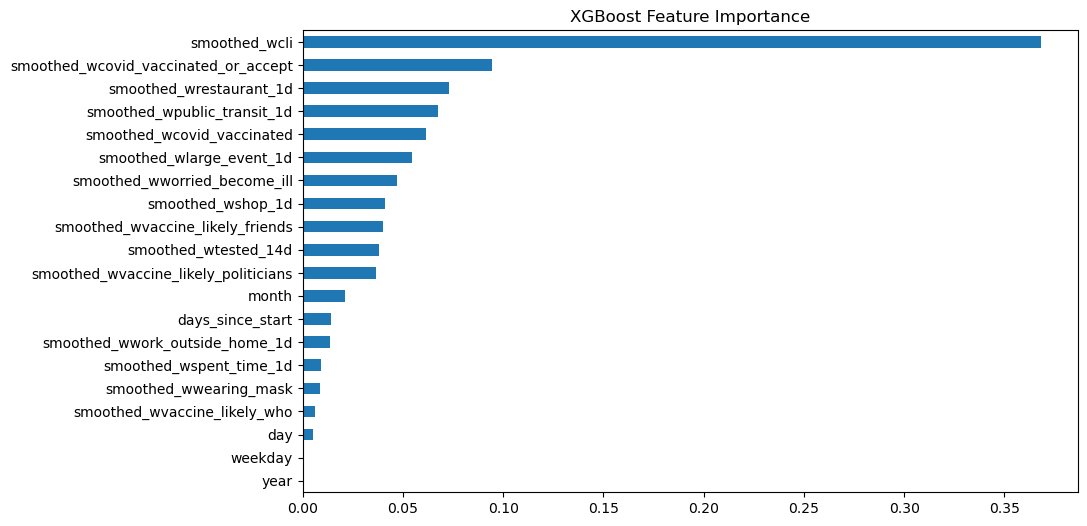

In [17]:
# XGBoost feature importance
xgb_model = fitted_models['XGBoost']
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
xgb_importance.head(20).plot(kind='barh')
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

### XGBoost Feature Importance Analysis: COVID Positivity Prediction

After training the XGBoost model to predict **`smoothed_wtested_positive_14d`**, we examined the most influential features driving predictions.

The top predictors (by feature importance) were:

1. **`smoothed_wcli`** — The most significant predictor. This variable captures self-reported COVID-like illness (CLI) symptoms and strongly correlates with actual positivity rates.
2. **`smoothed_wcovid_vaccinated_or_accept`** — Counties with higher vaccine acceptance show lower predicted positivity, indicating a protective population-level effect.
3. **Behavioral Indicators** such as:
   - `smoothed_wrestaurant_1d`
   - `smoothed_wpublic_transit_1d`
   - `smoothed_wlarge_event_1d`  
   These reflect public activity and potential exposure risk.
4. **Perceptual Variables**:
   - `smoothed_wworried_become_ill` shows that counties where individuals are more concerned about becoming ill tend to have higher positivity — potentially signaling better self-awareness or higher local transmission.

Lower-ranked but still relevant features included:
- `smoothed_wvaccine_likely_friends`, `smoothed_wtested_14d`, and various **temporal markers** (`month`, `days_since_start`).

---

### Interpretation

This feature ranking supports the conclusion that **community illness perception**, **vaccination status**, and **risk behaviors** are key drivers of COVID-19 positivity rates. These insights can inform future:
- Targeted public health messaging
- Behavioral interventions
- Cluster-level surveillance strategies
